In [ ]:
def download(t, s, e):
  df = yf.download(t, start=s, end=e)
  df['Ticker'] = t
  df = df.reset_index()
  df['mes'] = pd.to_numeric(df['Date'].dt.strftime('%Y%m'))
  return df
  
def save_data(df, df_all):
    df_all = pd.concat([df, df_all], axis=0)
    return df_all

def recorrido_soporte(dataset, fecha_empieza_vigencia, valor_soporte, rango_quebrado, df_all, prueba_nro):
  dataset = dataset[dataset.Date > fecha_empieza_vigencia]
  dataset['rango_quebrado_inicia'] = valor_soporte * (1-rango_quebrado)
  dataset['valor'] = valor_soporte
  dataset['rango_quebrado_termina'] = valor_soporte * (1+rango_quebrado)
  dataset['es_zona_prueba'] = np.where((dataset['Low'] < dataset['valor']) & (dataset['High'] > dataset['valor']), 1, 0)
  dataset['es_zona_confirmacion'] = np.where((dataset['High'] > dataset['rango_quebrado_termina']), 1, 0)
  dataset['es_zona_quiebre'] = np.where((dataset['Low'] < dataset['rango_quebrado_inicia']), 1, 0)
  mascara_probado = (dataset.es_zona_prueba == 1)
  mascara_quebrado = (dataset.es_zona_quiebre == 1)
  if len(dataset[mascara_probado]) == 0 & len(dataset[mascara_quebrado]) == 0:                            # NO FUE PROBADO NI QUEBRADO
    resolucion = 'vigente'
    fecha_prueba = np.nan
    fecha_resolucion = np.nan
    print('La prueba número ', prueba_nro, 'nunca se realizó en la historia') if Logging else None
  elif len(dataset[mascara_probado]) == 0:                                                                # QUEBRADO SIN PROBARSE
    resolucion = 'quebrado sin probarse nunca'
    fecha_prueba = np.nan
    fecha_resolucion = np.nan
    print('La prueba', prueba_nro, 'nunca se realizó, pero el soporte fue quebrado') if Logging else None
  else:
    fecha_prueba = dataset[mascara_probado].iloc[0].Date
    resolucion = ''
    if len(dataset[mascara_quebrado]) > 0:
      fecha_quiebre = dataset[mascara_quebrado].iloc[0].Date
      if fecha_quiebre < fecha_prueba:      
        resolucion = 'quebrado'
        fecha_prueba = np.nan
        fecha_resolucion = fecha_quiebre
        print('La prueba', prueba_nro, 'fue quebrada antes de probarse') if Logging else None
    if resolucion != 'quebrado':
      print('La prueba número ', prueba_nro, 'empezó el día ', fecha_prueba, ' cuando el mínimo fue ', dataset[mascara_probado].iloc[0].Low, ' y el máximo fue ', dataset[mascara_probado].iloc[0].High) if Logging else None
      mascara_resuelto = ((dataset.Date > fecha_prueba)&(dataset.es_zona_confirmacion == 1))|((dataset.Date > fecha_prueba)&(dataset.es_zona_quiebre == 1))
      if len(dataset[mascara_resuelto]): # La prueba fue resuelta
        fecha_resolucion = dataset[mascara_resuelto].iloc[0].Date
        print('Fue resuelta el día ', fecha_resolucion, ' cuando el mínimo fue ', dataset[mascara_resuelto].iloc[0].Low, ' y el máximo fue ', dataset[mascara_resuelto].iloc[0].High) if Logging else None
        if (dataset[mascara_resuelto].iloc[0].es_zona_confirmacion == 1) & (dataset[mascara_resuelto].iloc[0].es_zona_quiebre == 1):
          resolucion = 'indeterminado por resolverse el mismo día'
          print('La prueba número ', prueba_nro, 'completó la historia sin ser determinada') if Logging else None
        elif dataset[mascara_resuelto].iloc[0].es_zona_confirmacion == 1:
          resolucion = 'probado'
          print('La prueba número ', prueba_nro, 'completó la historia probada el día ', fecha_resolucion) if Logging else None
        elif dataset[mascara_resuelto].iloc[0].es_zona_quiebre == 1:
          resolucion = 'quebrado'
          print('La prueba número ', prueba_nro, 'completó la historia quebrada el día ', fecha_resolucion) if Logging else None
      else:
        fecha_resolucion = np.nan
        resolucion = 'indeterminado por no resolverse nunca'
        print('No llegó a resolverse en el mes.') if Logging else None
  analisis_prueba_list = []
  analisis_prueba_list.append([ticker+str(round(valor_soporte,2)), ticker, valor_soporte, fecha_empieza_vigencia, prueba_nro, fecha_prueba, fecha_resolucion, resolucion])
  analisis_prueba = pd.DataFrame(analisis_prueba_list, columns = ["id_soporte", "ticker", "valor", "fecha_ingreso_vigencia", "nro_prueba_historia", "fecha_prueba", "fecha_resolucion", "tipo_resolucion"])
  analisis_prueba['fecha_prueba'] = pd.to_datetime(analisis_prueba['fecha_prueba'])
  analisis_prueba['fecha_resolucion'] = pd.to_datetime(analisis_prueba['fecha_resolucion'])

  df_all = save_data(df_all, analisis_prueba)
  if resolucion == 'probado':
    print('La prueba número ', prueba_nro, 'admite nuevas pruebas') if Logging else None
    prueba_nro = prueba_nro + 1
    dataset = dataset[dataset.Date > fecha_resolucion]
    return recorrido_soporte(dataset, fecha_empieza_vigencia, valor_soporte, rango_quebrado, df_all, prueba_nro)
  else:
    return df_all

def calculo_soportes_historia(df, lags, rango_quiebre_soportes):
  i = 1
  while i < (lags+1): # Genera ventanas alrededor para analizar si es soporte
      colname = 'l%sb' % (i)                                                  
      df[colname] = round(df[armar_soportes_con].shift(i),2)
      colname = 'l%sf' % (i)                                                  
      df[colname] = round(df[armar_soportes_con].shift(-i),2)
      i = i + 1
  x = np.arange(len(df.Date))
  df['minb'] = round(df.filter(regex=("l.*b")).min(axis=1),2)
  df['minf'] = round(df.filter(regex=("l.*f")).min(axis=1),2)
  df['Soporte'] = np.where((df.index > lags) & (df[armar_soportes_con]<df['minb']) & (df[armar_soportes_con]<df['minf']), 1, 0)
  df['Soporte'] = np.where((df.index > (df.shape[0] - lags)), 0 , df.Soporte * df[armar_soportes_con])
  df = df[['Date', 'Ticker', 'Close', 'Low', 'High', 'Soporte']]
  df.replace(0, np.nan, inplace=True)
  puntos_soporte = df[df.Soporte > 0]['Soporte'].to_numpy() # Lista de soportes
  df['Date_vigencia'] = df.Date.shift(-lags)
  fechas_soporte = df[df.Soporte > 0]['Date'].to_numpy() # Lista de fechas de soporte
  fechas_vigencia_soporte = df[df.Soporte > 0]['Date_vigencia'].to_numpy() # Lista de fechas de soporte
  df_all = pd.DataFrame()
  i = 0
  print("\n", "Análisis de soportes fijos: ") if Logging else None
  while i < len(puntos_soporte):  # Recorre la lista de soportes
    print('Analizo el punto de soporte ', round(puntos_soporte[i], 2), ' del día ', fechas_soporte[i],' que entraría en vigencia el día ', fechas_vigencia_soporte[i]) if Logging else None
    df_all = recorrido_soporte(df, fechas_vigencia_soporte[i], puntos_soporte[i], rango_quiebre_soportes, df_all, 1)
    i = i + 1
  return df_all

def calculo_resistencias_quebradas_historia(df, lags, rango_quiebre_soportes):
  i = 1
  while i < (lags+1): # Genera ventanas alrededor para analizar si es resistencia
      colname = 'h%sb' % (i)                                                  
      df[colname] = round(df[armar_resistencias_con].shift(i),2)
      colname = 'h%sf' % (i)                                                  
      df[colname] = round(df[armar_resistencias_con].shift(-i),2)
      i = i + 1
  x = np.arange(len(df.Date))
  df['maxb'] = round(df.filter(regex=("h.*b")).max(axis=1),2)
  df['maxf'] = round(df.filter(regex=("h.*f")).max(axis=1),2)
  df['Resistencia'] = np.where((df.index > lags) & (df[armar_resistencias_con]>df['maxb']) & (df[armar_resistencias_con]>df['maxf']), 1, 0)
  df['Resistencia'] = np.where((df.index > (df.shape[0] - lags)), 0 , df.Resistencia * df[armar_resistencias_con])
  df = df[['Date', 'Ticker', 'Close', 'High', 'Low', 'Resistencia']]
  df['Date_vigencia'] = df.Date.shift(-lags)
  df.replace(0, np.nan, inplace=True)
  puntos_resistencia = df[df.Resistencia > 0]['Resistencia'].to_numpy()
  fechas_resistencia = df[df.Resistencia > 0]['Date'].to_numpy() # Lista de fechas de soporte
  fechas_vigencia_resistencia = df[df.Resistencia > 0]['Date_vigencia'].to_numpy() # Lista de fechas de soporte
  df_all = pd.DataFrame()
  i = 0
  j = 0
  print("\n", "Análisis de resistencias fijas quebradas: ") if Logging else None
  while i < len(puntos_resistencia):  # Recorre la lista de resistencias
    print('Analizo el punto de resistencia ', round(puntos_resistencia[i], 2), ' del día ', fechas_resistencia[i], ' que entra en vigencia el día ', fechas_vigencia_resistencia[i]) if Logging else None
    mascara_resistencia_quebrada = (df.Date > fechas_vigencia_resistencia[i]) & (df[armar_resistencias_con] > (puntos_resistencia[i] * (1+rango_quiebre_soportes)))
    if len(df[mascara_resistencia_quebrada]) == 0:
      print(' Nunca fue quebrado hacia arriba') if Logging else None
    else:
      fecha_quiebre_resistencia = df[mascara_resistencia_quebrada].Date.iloc[0]
      print(' Fue quebrado hacia arriba el día ', fecha_quiebre_resistencia, '. Lo analizo como soporte') if Logging else None
      df_all = recorrido_soporte(df, fecha_quiebre_resistencia, puntos_resistencia[i], rango_quiebre_soportes, df_all, 1)
    i = i + 1
  return df_all

def deduplica_soportes(v, d):
  valores_unicos = []
  a = v.valor.to_numpy()
  i = 0
  while i <= len(a) - 1:
    j = 0
    nuevo = "Si"
    while j < i:
      if (a[j] < (a[i]*(1-d))) or (a[j] > (a[i]*(1+d))):
        nuevo = nuevo
      else:
        nuevo = "No"
      j = j + 1
    if nuevo == "Si":
      valores_unicos.append(a[i])
    i = i + 1
  return valores_unicos

def selecciona_soporte(l, p):
  precio_limite = p * 0.96
  candidato = np.max(l)
  ratio_candidato = candidato/p
  if (ratio_candidato < 0.9):
    soporte = p * 0.9
  elif (ratio_candidato >= 0.9) & (ratio_candidato < 0.96):
    soporte = candidato
  elif (ratio_candidato > 0.96):
    l = [item for item in l if item < precio_limite]
    candidato_2 = np.max(l)
    if (candidato_2/p < 0.9):
      soporte = candidato * 0.97
    elif (candidato_2/p >= 0.9):
      soporte = candidato_2
  return soporte

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


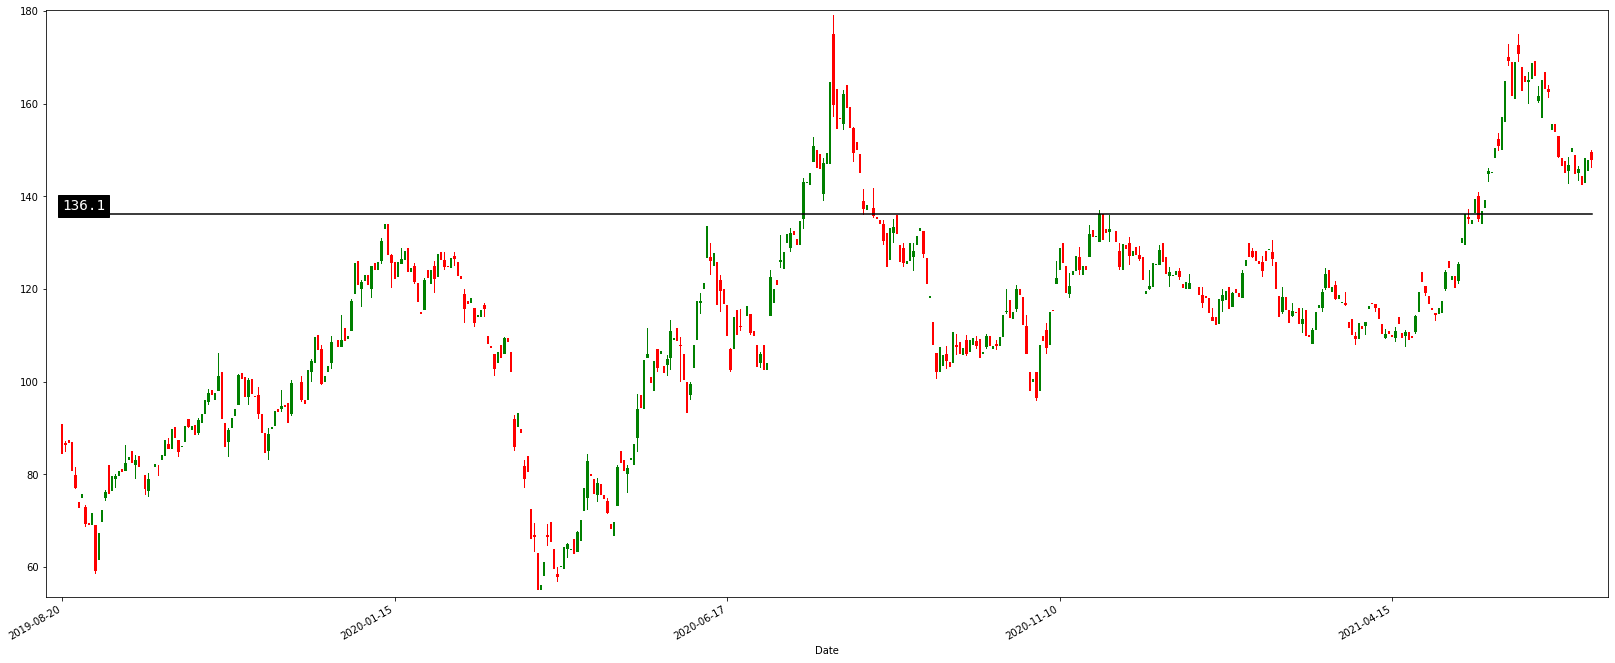

In [ ]:
empieza = date.today() + timedelta(days=-numero_dias)
termina = date.today() + timedelta(days=1)

ticker = 'GGAL.BA'
fecha_analisis = '2021-07-15'

Logging = False
base = download(ticker, empieza, termina)
cierre_fecha_analisis = base[base.Date <= fecha_analisis].iloc[-1].Close

df_all_sv = calculo_soportes_historia(base, ventana_puntos, rango_quebrado)
df_all_rq = calculo_resistencias_quebradas_historia(base, ventana_puntos, rango_quebrado)

# Falta función que saque todo lo repetido, es decir que para cada punto independientemente de lo que vino antes, analice lo vigente a ese día y borre la fila si ya había algo
df_all = pd.concat([df_all_sv, df_all_rq], axis=0)

mascara_iniciados_antes = (df_all.fecha_ingreso_vigencia < fecha_analisis)
mascara_vigentes_hoy = (df_all.tipo_resolucion == 'vigente')
mascara_quebrados_despues = ((df_all.tipo_resolucion == 'quebrado') & (df_all.fecha_resolucion > fecha_analisis))
vigentes = df_all[mascara_iniciados_antes & (mascara_vigentes_hoy|mascara_quebrados_despues)].sort_values(by=['fecha_ingreso_vigencia'])
vigentes_deduplicados = deduplica_soportes(vigentes, rango_probado)
soporte = selecciona_soporte(vigentes_deduplicados, cierre_fecha_analisis)

plt.rcParams["figure.figsize"] = (28,12)
base = download(ticker, empieza, fecha_analisis)

if Plotting:
  f, ax = plt.subplots()

plot_serie_velas(base)

ax.plot(x, np.array([soporte for s in range(len(x))]), 'black')
ax.text(0, soporte*1.0075, str(round(soporte,2)), size='x-large', fontfamily = 'monospace', backgroundcolor = 'black', color = 'white') if Plotting else None

plot_no_blanks(f, ax, base.Date)
ax.margins(0.01, tight=True) 